In [118]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import numpy as np
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from collections import defaultdict
from collections import Counter
import statsmodels.api as sm

# load data
parts = pd.read_csv('Data/parts.csv')
sets = pd.read_csv('Data/sets.csv')
colors = pd.read_csv('Data/colors.csv')
inventories = pd.read_csv('Data/inventories.csv')
inventory_parts = pd.read_csv('Data/inventory_parts.csv')
minifigs = pd.read_csv('Data/minifigs.csv')
inventory_sets = pd.read_csv('Data/inventory_sets.csv')
inventory_minifigs = pd.read_csv('Data/inventory_minifigs.csv')
minifigures = pd.read_csv('Data/minifigs.csv')
categories = pd.read_csv('Data/part_categories.csv')
themes = pd.read_csv('Data/themes.csv')

In [119]:
##### merge data  #####

# merge left side of data structure
# merge categories with parts
categories_with_parts = pd.merge(categories, parts, left_on='id', right_on='part_cat_id')
categories_with_parts.rename(columns={'name_x': 'category_name', 'name_y': 'part_name', 'id': 'category_id'}, inplace=True)
categories_with_parts.drop('part_cat_id', axis=1, inplace=True)

# merge categories and parts with inventory_parts
categories_with_parts_with_inventory_parts = pd.merge(categories_with_parts, inventory_parts, left_on='part_num', right_on='part_num')
categories_with_parts_with_inventory_parts.drop('img_url', axis=1, inplace=True)

# merge inventory_parts with colors
categories_with_parts_with_colors_inventory_parts = pd.merge(categories_with_parts_with_inventory_parts, colors, left_on='color_id', right_on='id')
categories_with_parts_with_colors_inventory_parts.drop('color_id', axis=1, inplace=True)
categories_with_parts_with_colors_inventory_parts.rename(columns={'id': 'color_id', 'name': 'color_name', 'quantity': 'part_quantity'}, inplace=True)
categories_with_parts_with_colors_inventory_parts.to_csv('Merged_Data/inventory_parts.csv', index=False)


# merge middle of data structure
# merge minifgures with inventory_minifgures
minifigures_with_inventory_minifgures = pd.merge(minifigs, inventory_minifigs, left_on='fig_num', right_on='fig_num')
minifigures_with_inventory_minifgures.rename(columns={'name': 'minifig_name', 'quantity': 'minifig_quantitiy'}, inplace=True)
minifigures_with_inventory_minifgures.drop('img_url', axis=1, inplace=True)
minifigures_with_inventory_minifgures.to_csv('Merged_Data/inventory_minifigs.csv', index=False)

# merge right side of data structure
# merge sets with themes
sets_with_themes = pd.merge(sets, themes, left_on='theme_id', right_on='id')
sets_with_themes.drop(['img_url','theme_id', 'parent_id'], axis=1, inplace=True)
sets_with_themes.rename(columns={'name_x': 'set_name', 'id': 'theme_id', 'name_y': 'theme_name'}, inplace=True)
# sets_with_themes = sets_with_themes[sets_with_themes.num_parts != 0]                  # delete all things that has no Lego parts
theme_names = sets_with_themes['theme_name'].unique()                                   # print themes
for name in theme_names:
    print(name)
sets_with_themes['theme_id'] = sets_with_themes.groupby('theme_name').ngroup() + 1      # merge themes
sets_with_themes.to_csv('Merged_Data/inventory_sets.csv', index=False)

"""
# merge sets and themes with inventory_sets
sets_with_themes_inventory_sets = pd.merge(sets_with_themes, inventory_sets, left_on='set_num', right_on='set_num')
sets_with_themes_inventory_sets.rename(columns={'quantity': 'set_quantity'}, inplace=True)
sets_with_themes_inventory_sets.info()
sets_with_themes_inventory_sets.to_csv('Merged_Data/inventory_sets.csv', index=False)
"""

# merge all together
sets_with_inventory = pd.merge(sets_with_themes, inventories, left_on='set_num', right_on='set_num')

parts_with_inventory = pd.merge(categories_with_parts_with_colors_inventory_parts, sets_with_inventory, left_on='inventory_id', right_on='id')
parts_with_inventory.drop('id', axis=1, inplace=True)
parts_with_inventory.rename(columns={'num_parts': 'number_of_parts'}, inplace=True)

minifigs_with_inventory = pd.merge(minifigures_with_inventory_minifgures, sets_with_inventory, left_on='inventory_id', right_on='id')
minifigs_with_inventory.drop('id', axis=1, inplace=True)
minifigs_with_inventory.rename(columns={'num_parts_x': 'number_of_minifig_parts', 'num_parts_y': 'number_of_parts'}, inplace=True)


# filter data for the full years
data_parts = parts_with_inventory[parts_with_inventory['year'] <= 2023]
data_minifigs = minifigs_with_inventory[minifigs_with_inventory['year'] <= 2023]


# save full data 
data_minifigs.to_csv('Merged_Data/data_minifigs.csv', index=False)
data_parts.to_csv('Merged_Data/data_parts.csv', index=False)


Technic
Classic Town
Lion Knights
Supplemental
Classic Castle
Books
Basic Set
Icons
Playhouse
Early Creator
Service Packs
Town
Jumbo Bricks
Video Games and Accessories
Duplo and Explore
Train
Bulk Bricks
4.5V
9V
Ultimate Collector Series
Hobby Sets
Bionicle
Creator Expert
World City
Discovery
Black Falcons
Pirates I
Seasonal
Trains
Castle
Christmas
Easter
Spider-Man
Clikits
Key Chain
Thanksgiving
LEGO Brand Store
Basketball
Hockey
Harry Potter
Model Team
Airport
Other
Knights Kingdom II
Modular Buildings
Factory
Town Plan
Fantasy Era
Pirates II
Kingdoms
Monster Fighters
Legoland
Mini
Creator
The Lord of the Rings
Desert
NXT
Construction
Educational and Dacta
Classic
Duplo
Cars
Building Set with People
Boat
Universal Building Set
Disney Planes
Jake and the Never Land Pirates
Disney Princess
Disney's Mickey Mouse
Ferries
DC Comics
Sofia the First
Doc McStuffins
Spiderman
Throwbot Slizer
Bricks & More
Juniors
Marvel Super Heroes
DC Comics Super Heroes
Extreme Team
Res-Q
Ninjago
Friends
Ju

In [120]:
##### Analysis over the years #####

# calculate mean number of parts per year per set
data_parts['part_quantity'] = data_parts['part_quantity'].astype(int)  
grouped_parts = data_parts.groupby(['set_num', 'year'])['part_quantity'].sum().reset_index()              # Sum part_quantity per set per year
mean_parts_per_set_per_year = grouped_parts.groupby('year')['part_quantity'].mean()                       # Calculate mean per year

print(mean_parts_per_set_per_year)

# calculate number of sets per year
grouped_sets = data_parts.groupby(['set_num', 'year']).size().reset_index(name='count')     # Count unique sets per year
sets_per_year = grouped_sets.groupby('year')['set_num'].count()                             # Calculate count per year

print(sets_per_year)

# calculate mean number of minifigs per year
data_minifigs['minifig_quantitiy'] = data_minifigs['minifig_quantitiy'].astype(int)
grouped_minifigs = data_minifigs.groupby(['set_num', 'year'])['minifig_quantitiy'].sum().reset_index() # Sum minifig_quantity per set per year
mean_minifigs_per_set_per_year = grouped_minifigs.groupby('year')['minifig_quantitiy'].mean()          # Calculate mean per year

print(mean_minifigs_per_set_per_year)

# calculate the mean number of colors per set
grouped_colors_per_set = data_parts.groupby(['set_num', 'color_name', 'year']).size().reset_index(name='count') # Count unique colors per set per year
grouped_colors = grouped_colors_per_set.groupby(['set_num', 'year'])['count'].sum().reset_index()               # Sum unique colors per set per year
mean_colors_per_set_per_year = grouped_colors.groupby('year')['count'].mean()                                   # Calculate mean per year

print(mean_colors_per_set_per_year)

# calculate number of colors per year
grouped_colors = data_parts.groupby(['color_name', 'year']).size().reset_index(name='count')    # Count unique colors per year
colors_per_year = grouped_colors.groupby('year')['color_name'].count()                          # Calculate count per year

print(colors_per_year)

# calculate mean number of unique parts per set per year
data_unique_parts = data_parts[data_parts['part_quantity'] == 1]                                            # Filter for parts with quantity 1
grouped_unique_parts = data_unique_parts.groupby(['set_num', 'year'])['part_num'].nunique().reset_index()   # Count unique parts per set per year
mean_unique_parts_per_set_per_year = grouped_unique_parts.groupby('year')['part_num'].mean()                # Calculate mean per year

print(mean_unique_parts_per_set_per_year)

# calculate the themes per year
grouped_themes = data_parts.groupby(['theme_name', 'year']).size().reset_index(name='count')    # Count unique themes per year
themes_per_year = grouped_themes.groupby('year')['theme_name'].count()                          # Calculate count per year

print(themes_per_year)



/var/folders/1z/94kl8yts6ls80stcsg7ld0lw0000gn/T/ipykernel_21547/2505596343.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_parts['part_quantity'] = data_parts['part_quantity'].astype(int)


year
1949    156.400000
1950      3.666667
1953     35.333333
1954     12.714286
1955     32.694444
           ...    
2019    310.211648
2020    344.904241
2021    410.123835
2022    418.008621
2023    419.798331
Name: part_quantity, Length: 73, dtype: float64


year
1949      5
1950      6
1953      3
1954     14
1955     36
       ... 
2019    704
2020    731
2021    751
2022    696
2023    719
Name: set_num, Length: 73, dtype: int64


/var/folders/1z/94kl8yts6ls80stcsg7ld0lw0000gn/T/ipykernel_21547/2505596343.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_minifigs['minifig_quantitiy'] = data_minifigs['minifig_quantitiy'].astype(int)


year
1975    4.111111
1976    2.923077
1977    2.833333
1978    2.305556
1979    2.574468
1980    2.757576
1981    2.517241
1982    3.857143
1983    2.967742
1984    2.542857
1985    3.237288
1986    2.254902
1987    2.306122
1988    3.305556
1989    3.553191
1990    2.816327
1991    3.720000
1992    2.711538
1993    2.983051
1994    2.456140
1995    2.250000
1996    3.417722
1997    2.272727
1998    2.086420
1999    2.000000
2000    2.804511
2001    2.333333
2002    3.046512
2003    2.580952
2004    4.342857
2005    4.410256
2006    5.467391
2007    4.201835
2008    4.236641
2009    3.768293
2010    3.688172
2011    2.932862
2012    2.646724
2013    2.631902
2014    2.583333
2015    2.839793
2016    2.594787
2017    2.545667
2018    2.408578
2019    2.644144
2020    2.939535
2021    2.960089
2022    2.794554
2023    2.829694
Name: minifig_quantitiy, dtype: float64
year
1949     34.200000
1950      3.666667
1953      8.666667
1954      7.785714
1955      7.361111
           ...    
201

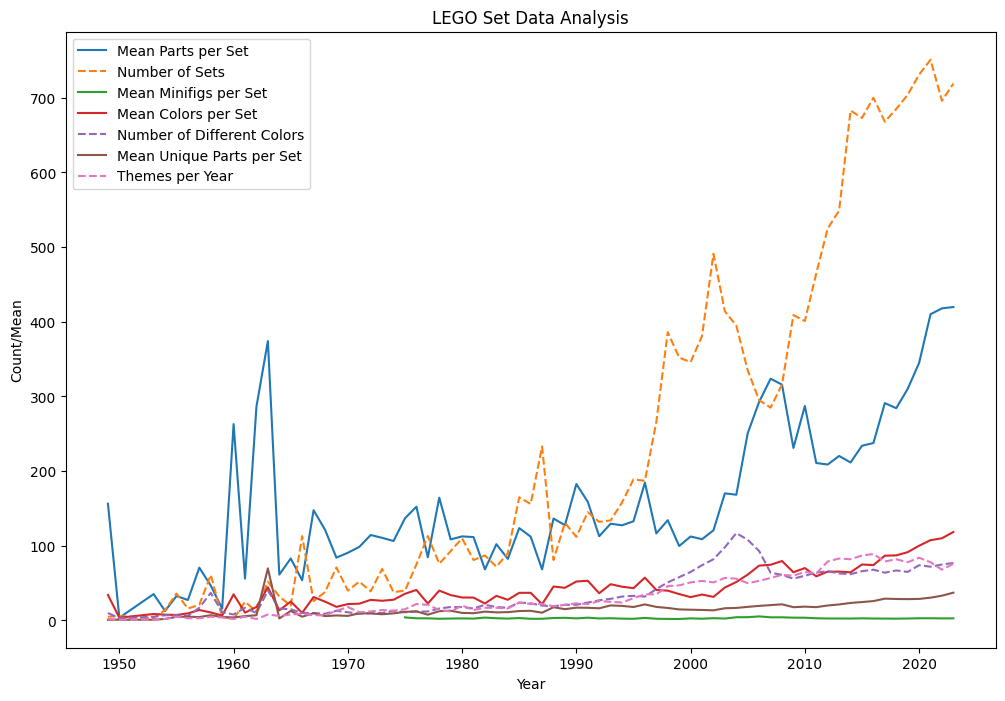

In [121]:
# Set up the plot for the analysis
plt.figure(figsize=(12, 8))

# Plot mean number of parts per set per year
plt.plot(mean_parts_per_set_per_year.index, mean_parts_per_set_per_year, label='Mean Parts per Set')

# Plot number of sets per year
plt.plot(sets_per_year.index, sets_per_year, label='Number of Sets', linestyle='--')

# Plot mean number of minifigs per set per year
plt.plot(mean_minifigs_per_set_per_year.index, mean_minifigs_per_set_per_year, label='Mean Minifigs per Set')

# Plot mean number of colors per set per year
plt.plot(mean_colors_per_set_per_year.index, mean_colors_per_set_per_year, label='Mean Colors per Set')

# Plot the number of colors per set per year
plt.plot(colors_per_year.index, colors_per_year, label='Number of Different Colors', linestyle='--')

# Plot mean number of unique parts per set per year
plt.plot(mean_unique_parts_per_set_per_year.index, mean_unique_parts_per_set_per_year, label='Mean Unique Parts per Set')

# Plot themes per year
plt.plot(themes_per_year.index, themes_per_year, label='Themes per Year', linestyle='--')

# Set plot labels and title
plt.xlabel('Year')
plt.ylabel('Count/Mean')
plt.title('LEGO Set Data Analysis')
plt.legend()

# Show the plot
plt.show()

/var/folders/1z/94kl8yts6ls80stcsg7ld0lw0000gn/T/ipykernel_21547/25823476.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['part_quantity'] = df['part_quantity'].astype(int)  # Ensure part_quantity is integer
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


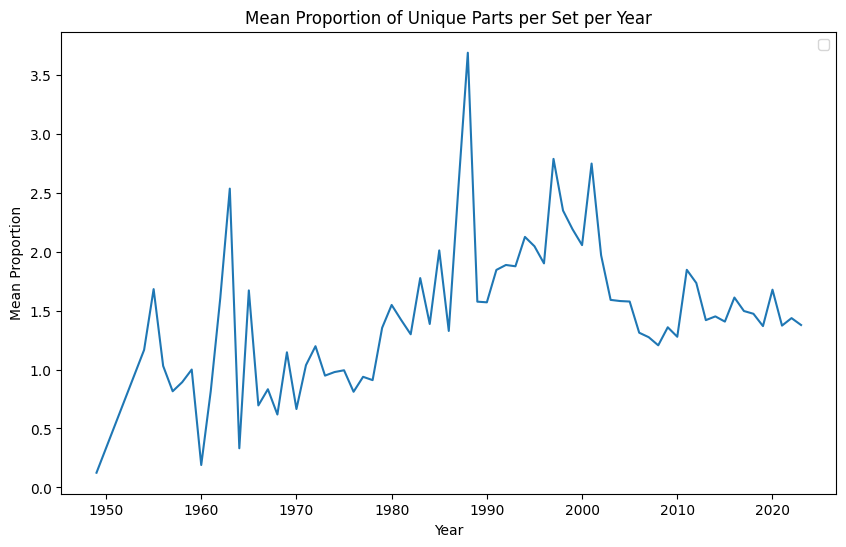

In [122]:
###### Plot the mean proportion of unique parts to not unique parts per set per year #####

def calculate_mean_proportion(df):
    df['part_quantity'] = df['part_quantity'].astype(int)  # Ensure part_quantity is integer

    # Calculate unique parts per set per year
    data_unique_parts = df[df['part_quantity'] == 1]
    unique_parts = data_unique_parts.groupby(['set_num', 'year'])['part_num'].nunique().reset_index()
    unique_parts.rename(columns={'part_num': 'unique_parts'}, inplace=True)

    # Calculate non-unique parts per set per year
    data_non_unique_parts = df[df['part_quantity'] > 1]
    non_unique_parts = data_non_unique_parts.groupby(['set_num', 'year'])['part_num'].nunique().reset_index()
    non_unique_parts.rename(columns={'part_num': 'non_unique_parts'}, inplace=True)

    # Merge the two dataframes
    data_proportion_parts = pd.merge(unique_parts, non_unique_parts, on=['set_num', 'year'])

    # Calculate the proportion
    data_proportion_parts['proportion'] = data_proportion_parts['unique_parts'] / data_proportion_parts['non_unique_parts']

    # Calculate the mean proportion for each year
    mean_proportion_per_year = data_proportion_parts.groupby('year')['proportion'].mean()

    return mean_proportion_per_year

def plot_mean_proportion(mean_proportion_per_year):
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(mean_proportion_per_year.index, mean_proportion_per_year)

    # Add title and labels
    plt.title('Mean Proportion of Unique Parts per Set per Year')
    plt.xlabel('Year')
    plt.ylabel('Mean Proportion')
    plt.legend()

    # Show the plot
    plt.show()

# Call the function with the result from 'calculate_mean_proportion'
mean_proportion_per_year = calculate_mean_proportion(data_parts)
plot_mean_proportion(mean_proportion_per_year)



In [123]:
##### find the different themes in the last 23 years #####

df_filtered = data_parts[(data_parts['year'] >= 2000) & (data_parts['year'] <= 2023)]       # Filter for years 2000 to 2023
grouped = df_filtered.groupby(['theme_name', 'year'])['set_num'].nunique().reset_index()    # Count unique sets per theme per year
grouped = grouped.groupby('theme_name')['set_num'].sum().reset_index()                      # Sum unique sets per theme
grouped = grouped.sort_values('set_num', ascending=False)                                   # Sort in descending order

print(grouped)

        theme_name  set_num
254      Star Wars      808
99         Friends      544
180        Ninjago      494
267        Technic      477
27           Books      350
..             ...      ...
165           Mini        1
170     Model Team        1
25   Black Falcons        1
18           Basic        1
287      Town Plan        1

[314 rows x 2 columns]


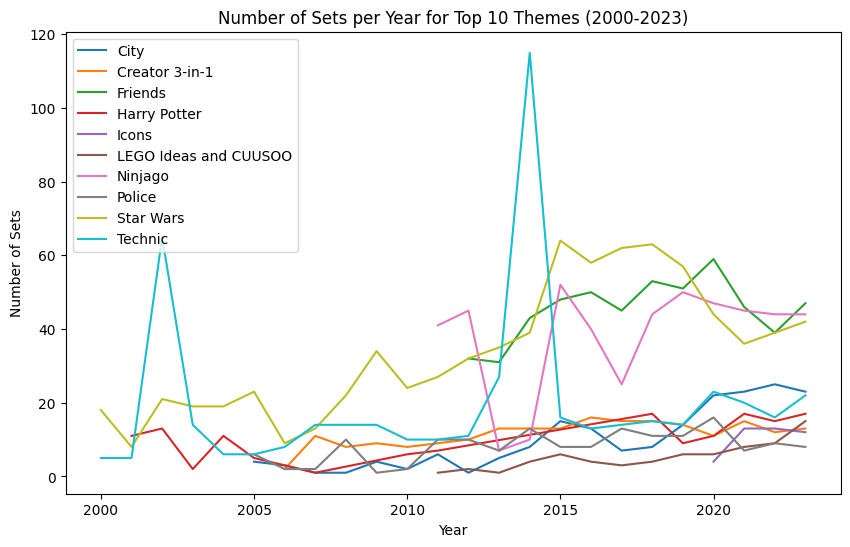

In [124]:
##### plot the top 10 themes over the years (2000 - 2023) #####

def plot_top_themes_and_sets(df):
    # Filter the DataFrame for the years 2000 to 2023
    df_filtered = df[(df['year'] >= 2000) & (df['year'] <= 2023)]

    # Find the top 10 themes
    top_themes = df_filtered['theme_name'].value_counts().nlargest(10).index.tolist()

    # Filter the DataFrame for the top 10 themes
    df_top_themes = df_filtered[df_filtered['theme_name'].isin(top_themes)]

    # Group by 'theme_name' and 'year', and count distinct 'set_num'
    sets_per_year = df_top_themes.groupby(['theme_name', 'year'])['set_num'].nunique()

    # Reset the index of the Series to use columns 'theme_name' and 'year' in the plot
    sets_per_year_reset = sets_per_year.reset_index()

    # Create the plot
    plt.figure(figsize=(10, 6))
    for theme in sets_per_year_reset['theme_name'].unique():
        data = sets_per_year_reset[sets_per_year_reset['theme_name'] == theme]
        plt.plot(data['year'], data['set_num'], label=theme)

    # Add title and labels
    plt.title('Number of Sets per Year for Top 10 Themes (2000-2023)')
    plt.xlabel('Year')
    plt.ylabel('Number of Sets')
    plt.legend()

    # Show the plot
    plt.show()

# Call the function
plot_top_themes_and_sets(data_parts)

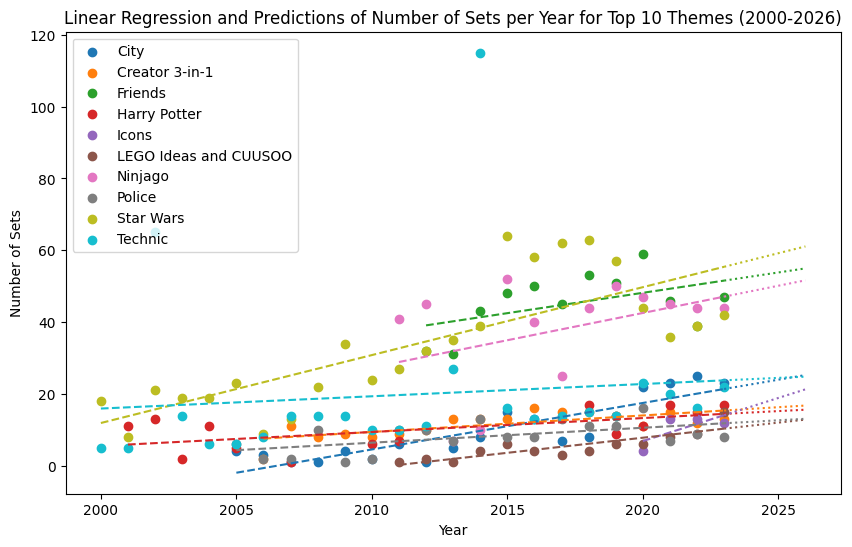

In [125]:
##### make a linear regression with a prediction for the next three years #####

def linear_regression_top_themes(df):
    # Filter the DataFrame for the years 2000 to 2023
    df_filtered = df[(df['year'] >= 2000) & (df['year'] <= 2023)]

    # Find the top 10 themes
    top_themes = df_filtered['theme_name'].value_counts().nlargest(10).index.tolist()

    # Filter the DataFrame for the top 10 themes
    df_top_themes = df_filtered[df_filtered['theme_name'].isin(top_themes)]

    # Group by 'theme_name' and 'year', and count distinct 'set_num'
    sets_per_year = df_top_themes.groupby(['theme_name', 'year'])['set_num'].nunique()

    # Reset the index of the Series to use columns 'theme_name' and 'year' in the plot
    sets_per_year_reset = sets_per_year.reset_index()

    # Create the plot
    plt.figure(figsize=(10, 6))
    for theme in sets_per_year_reset['theme_name'].unique():
        data = sets_per_year_reset[sets_per_year_reset['theme_name'] == theme]
        x = data['year'].values.reshape(-1, 1)
        y = data['set_num'].values
        model = LinearRegression().fit(x, y)
        y_pred = model.predict(x)
        plt.scatter(x, y, label=theme)
        plt.plot(x, y_pred, linestyle='--')

        # Make predictions until 2026
        x_future = np.arange(2023, 2027).reshape(-1, 1)
        y_future_pred = model.predict(x_future)
        plt.plot(x_future, y_future_pred, linestyle=':', color=plt.gca().lines[-1].get_color())

    # Add title and labels
    plt.title('Linear Regression and Predictions of Number of Sets per Year for Top 10 Themes (2000-2026)')
    plt.xlabel('Year')
    plt.ylabel('Number of Sets')
    plt.legend()

    # Show the plot
    plt.show()

# Call the function
linear_regression_top_themes(data_parts)

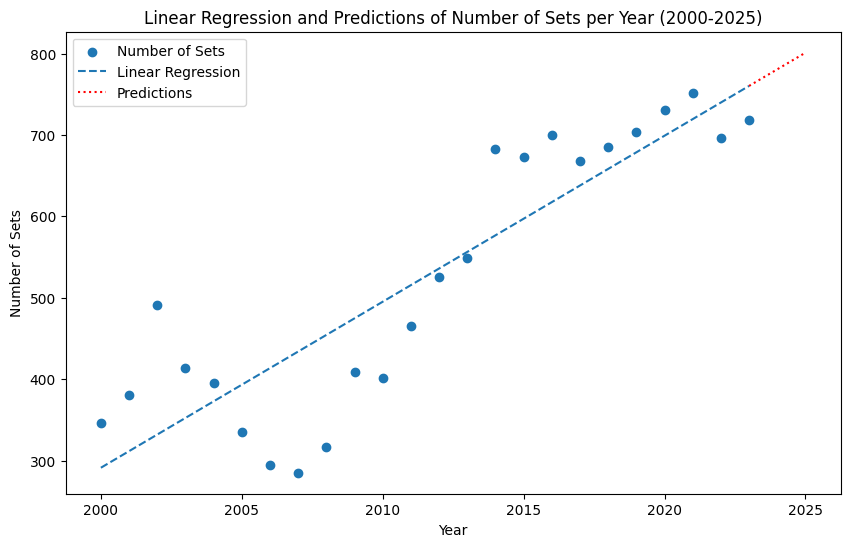

In [126]:
##### make a linear regression for the number of sets with prediction for three years #####

def linear_regression_sets(df):
    # Filter the DataFrame for the years 2000 to 2023
    df_filtered = df[(df['year'] >= 2000) & (df['year'] <= 2023)]

    # Group by 'year', and count distinct 'set_num'
    sets_per_year = df_filtered.groupby('year')['set_num'].nunique()

    # Reset the index of the Series to use column 'year' in the plot
    sets_per_year_reset = sets_per_year.reset_index()

    # Create the plot
    plt.figure(figsize=(10, 6))
    x = sets_per_year_reset['year'].values.reshape(-1, 1)
    y = sets_per_year_reset['set_num'].values
    model = LinearRegression().fit(x, y)
    y_pred = model.predict(x)
    plt.scatter(x, y, label='Number of Sets')
    plt.plot(x, y_pred, linestyle='--', label='Linear Regression')

    # Make predictions until 2025
    x_future = np.arange(2023, 2026).reshape(-1, 1)
    y_future_pred = model.predict(x_future)
    plt.plot(x_future, y_future_pred, linestyle=':', color='red', label='Predictions')

    # Add title and labels
    plt.title('Linear Regression and Predictions of Number of Sets per Year (2000-2025)')
    plt.xlabel('Year')
    plt.ylabel('Number of Sets')
    plt.legend()

    # Show the plot
    plt.show()

# Call the function
linear_regression_sets(data_parts)


/var/folders/1z/94kl8yts6ls80stcsg7ld0lw0000gn/T/ipykernel_21547/49432204.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['part_quantity'] = df_filtered['part_quantity'].astype(int)


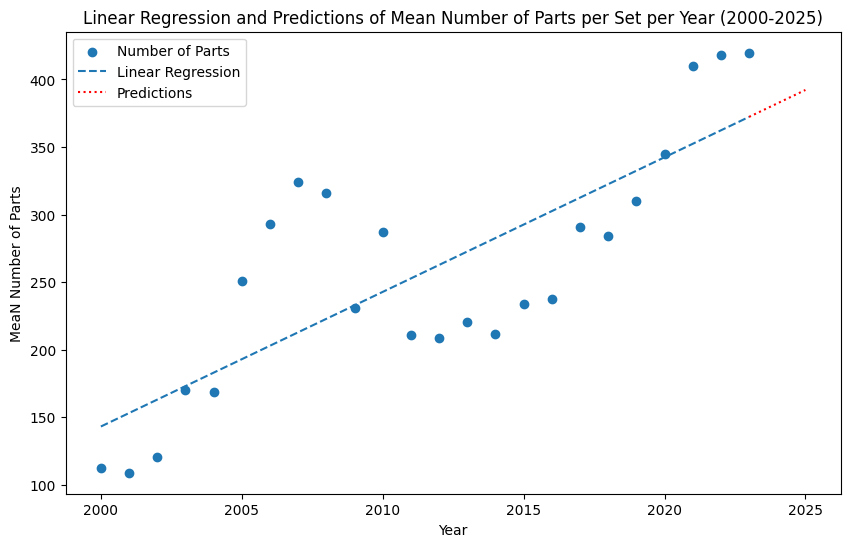

In [127]:
##### make a linear regression for the mean parts per set per year with prediction for the next three years #####

def linear_regression_parts(df):
    # Filter the DataFrame for the years 2000 to 2023
    df_filtered = df[(df['year'] >= 2000) & (df['year'] <= 2023)]
    df_filtered['part_quantity'] = df_filtered['part_quantity'].astype(int)  
    grouped_parts = df_filtered.groupby(['set_num', 'year'])['part_quantity'].sum().reset_index()              # Sum part_quantity per set per year
    mean_parts_per_set_per_year = grouped_parts.groupby('year')['part_quantity'].mean().reset_index()          # Calculate mean per year

    # Create the plot
    plt.figure(figsize=(10, 6))
    x = mean_parts_per_set_per_year['year'].values.reshape(-1, 1)
    y = mean_parts_per_set_per_year['part_quantity'].values
    model = LinearRegression().fit(x, y)
    y_pred = model.predict(x)
    plt.scatter(x, y, label='Number of Parts')
    plt.plot(x, y_pred, linestyle='--', label='Linear Regression')

    # Make predictions until 2025
    x_future = np.arange(2023, 2026).reshape(-1, 1)
    y_future_pred = model.predict(x_future)
    plt.plot(x_future, y_future_pred, linestyle=':', color='red', label='Predictions')

    # Add title and labels
    plt.title('Linear Regression and Predictions of Mean Number of Parts per Set per Year (2000-2025)')
    plt.xlabel('Year')
    plt.ylabel('MeaN Number of Parts')
    plt.legend()

    # Show the plot
    plt.show()

# Call the function with
linear_regression_parts(data_parts)
